In [1]:
import time
from usid_processing import parallel_compute
from functools import partial

import galsim

from utils import *
from model import *

############################################
# Setup
############################################

# Fitting Parameter
n_cpu = 3
RUN_FITTING = True
draw = True
mask_strip = True
mask_dual = True
wid_strip, n_strip = 5, 10
dir_name = "./run"

In [11]:
# Image Parameter
image_size = 400
n_star = 400
pixel_scale = 2.5                                # arcsec/pixel
psf_scale = 1.5                                  # arcsec/pixel

# PSF Parameters
beta_psf = 10                                     # moffat beta, in arcsec
fwhm = 2.28 * pixel_scale                         # moffat fwhm, in arcsec

gamma = fwhm / 2. / np.sqrt(2**(1./beta_psf)-1)  # moffat core width, in arcsec
gamma_pix = gamma / pixel_scale                  # moffat core width, in pix

n = 2.8                     # true power index
frac = 0.25                 # fraction of power law component
theta_t = 5.                # radius at which power law is flattened, in arcsec
theta_t_pix = theta_t/pixel_scale          # flattened radius, in pix

noise_variance = 10                        # sky variance
mu = 884                                   # sky mean
sigma = np.sqrt(noise_variance)            # sky stddev

In [12]:
############################################
# Distribution
############################################

# Generate Grid
yy, xx = np.mgrid[:image_size, :image_size]
cen = ((image_size-1)/2., (image_size-1)/2.)

# Generate randomn star positions
np.random.seed(626)
star_pos = (image_size-2) * np.random.random(size=(n_star,2)) + 1

# Flux from SE measurement based on APASS (intentionally X 2)
SE_cat_full = Table.read("./SE_APASS/coadd_SloanR_NGC_5907.cat", format="ascii.sextractor").to_pandas()
Flux_Auto_SE = SE_cat_full[(SE_cat_full.FLAGS<8)]["FLUX_AUTO"] * 2

# Star flux sampling from SE catalog
np.random.seed(626)
Flux = Flux_Auto_SE.sample(n=n_star).values

# Convert Flux to Astropy Moffat Amplitude (pixel)
Amps_mof = np.array([moffat2d_Flux2Amp(gamma_pix, beta_psf, Flux=(1-frac)*F) for F in Flux])
Amps_pow = np.array([power2d_Flux2Amp(n, theta_t_pix, Flux=frac*F) for F in Flux])

# Thresholds affecting speed and accuracy depending on the actual PSF, noise level, and magnitude distribution of stars.
# Non-bright stars are rendered with moffat only in advance.Very bright stars are rendered in real space.
F_bright = 3e4
F_verybright = 8e5
bright = Flux > F_bright
verybright = Flux > F_verybright
medbright = bright & (~verybright)
num_medbright = len(Flux[medbright])
num_verybright = len(Flux[verybright])
print("# of medium bright (flux:%.2g~%.2g) stars: %d "%(Flux[bright].min(), Flux[verybright].min(), num_medbright))
print("# of very bright (flux>%.2g) stars : %d"%(Flux[verybright].min(), num_verybright))

# Rendering stars in parallel if number of bright stars exceeds 50
if num_medbright < 50:
    print("Not many bright stars, truth and mock will be generated in serial.")
    parallel = False 
else: 
    parallel = True
    print("Crowded fields with bright stars > 50, truth and mock will be generated in parallel.")

    p_map2d = partial(map2d, xx=xx, yy=yy)

# of medium bright (flux:3e+04~9.4e+05) stars: 62 
# of very bright (flux>9.4e+05) stars : 7
Crowded fields with bright stars > 50, truth and mock will be generated in parallel.


PSF size (pix): (96.00, 384.00)


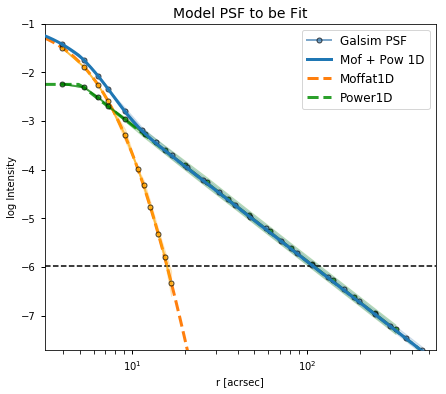

In [13]:
############################################
# Setup PSF
############################################

# Define the Power PSF profile  for making truth of medium/very bright stars if using galsim.
psf_pow_1, psf_size_1 = Generate_PSF_pow_Galsim(n=n, theta_t=theta_t,
                                                psf_range=64*pixel_scale,
                                                psf_scale=psf_scale)
psf_pow_2, psf_size_2 = Generate_PSF_pow_Galsim(n=n, theta_t=theta_t,
                                                psf_range=image_size//2*pixel_scale, 
                                                psf_scale=psf_scale)
psf_size_1 = round_good_fft(psf_size_1*psf_scale/pixel_scale)
psf_size_2 = round_good_fft(psf_size_2*psf_scale/pixel_scale)
print("PSF size (pix): (%.2f, %.2f)"%(psf_size_1, psf_size_2))

# Define the Moffat PSF profile.
gsparams = galsim.GSParams(folding_threshold=1.e-10)
psf_mof = galsim.Moffat(beta=beta_psf, flux=1., fwhm=fwhm, gsparams=gsparams) # in arcsec

if draw:
    star_psf_2 = (1-frac) * psf_mof + frac * psf_pow_2 
    
    img_pow_2 = psf_pow_2.drawImage(scale=pixel_scale, method="no_pixel").array
    img_mof = psf_mof.drawImage(scale=pixel_scale, method="no_pixel").array
    img_gs_2 = star_psf_2.drawImage(nx=image_size, ny=image_size, scale=pixel_scale, method="no_pixel").array
    
    plt.figure(figsize=(7,6))
    
    r_rbin, z_rbin, logzerr_rbin = cal_profile_1d((1-frac)*img_mof, pix_scale=pixel_scale, seeing=2.5, 
                                                 core_undersample=True,xunit="arcsec", yunit="intensity", color="orange")
    r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(frac*img_pow_2, pix_scale=pixel_scale, seeing=2.5, 
                                                 core_undersample=True,xunit="arcsec", yunit="intensity", color="g")
    r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(img_gs_2, pix_scale=pixel_scale, seeing=2.5,
                                                 core_undersample=True,xunit="arcsec", yunit="intensity", label="Galsim PSF")

    # Astropy 1D models. The agreement with Galsim model shows the normalization match correctly.
    r = np.logspace(0.1,2.5,100)
    C_mof2Dto1D =  1./(beta_psf-1) * 2*math.sqrt(np.pi) * gamma_pix * Gamma(beta_psf) / Gamma(beta_psf-1./2) 
    comp1 = moffat1d_normed(r, gamma=gamma_pix, alpha=beta_psf) / C_mof2Dto1D

    C_pow2Dto1D = np.pi * theta_t_pix * (n-1) / (n-2)
    comp2 = trunc_power1d_normed(r, n, theta_t_pix) / C_pow2Dto1D

    plt.plot(r*pixel_scale, np.log10((1-frac) * comp1 + comp2 * frac), ls="-", lw=3, label="Mof + Pow 1D",zorder=5)
    plt.plot(r*pixel_scale, np.log10((1-frac) * comp1), ls="--", lw=3, label="Moffat1D",zorder=1)
    plt.plot(r*pixel_scale, np.log10(comp2 * frac), ls="--",lw=3,  label="Power1D")

    plt.xscale("log")
    plt.axhline(np.log10(img_pow_2.max()/(Amps_pow.max()/sigma*3)),color="k",ls="--")
    plt.title("Model PSF to be Fit",fontsize=14)
    
    plt.legend(fontsize=12)
    plt.ylim(np.log10(z_rbin[-1]),-1)


Generate noise background w/ stddev = 3.2.
Generate base image of faint stars (flux < 2.7e+04).
Total Time: 0.156s
Generate the truth image (faint stars with Moffat only).
Rendering bright stars in parallel...
Total Time: 4.910s


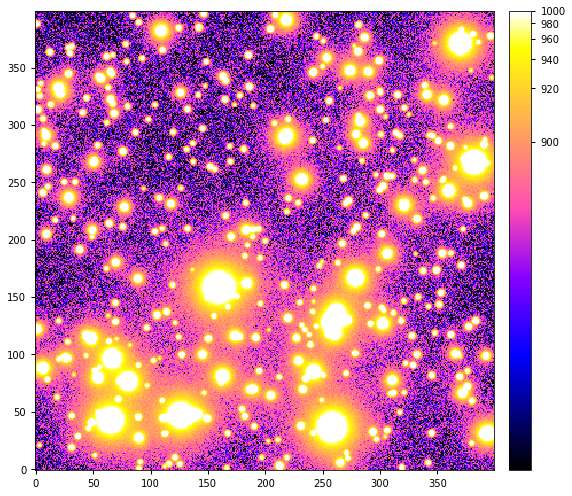

In [19]:
############################################
# Setup Image
############################################

# Setup the noise background
print("Generate noise background w/ stddev = %.2g."%sigma)
noise_image = make_noise_image(image_size, noise_variance)

# Setup the base image for faint stars (Moffat only):
print("Generate base image of faint stars (flux < %.2g)."%(Flux[~bright].max()))
image_gs0 = make_base_image(image_size, star_pos=star_pos[~bright], Flux=Flux[~bright], psf_base=psf_mof)

                   
# Make the truth image to be fitted (Moffat+power):
def make_truth_image(image_size, star_pos, Flux, noise, 
                     method="Real", Amps=Amps_mof, parallel=parallel,
                     F_min=1e3, saturation=4.5e4):
    
    """ Build Truth image with the position, flux and noise. 
    Two methods provided: 1) Galsim convolution in FFT and 2) Astropy model in real space. 
    [xx, yy, frac, bright, psf_mof, psf_pow is defined in the main.] """
    start = time.time()
    if method == "Galsim":
        full_image = galsim.ImageF(image_size, image_size)
                   
        for k, (pos, flux) in enumerate(zip(star_pos, Flux)): 
            if flux < F_min:  # very faint stars, simply assume truth is pure mofffat
                psf_star = psf_mof
            elif flux < F_verybright: 
                psf_star = (1-frac) * psf_mof + frac * psf_pow_1
                psf_size = psf_size_1
            else:
                psf_star = (1-frac) * psf_mof + frac * psf_pow_2
                psf_size = psf_size_2 
                
            star = psf_star.withFlux(flux)
            (ix_nominal, iy_nominal), offset = get_center_offset(pos)

            stamp = star.drawImage(nx=psf_size, ny=psf_size, scale=pixel_scale,
                                   offset=offset, method='no_pixel')
            
            stamp.setCenter(ix_nominal, iy_nominal)
            try:
                bounds = stamp.bounds & full_image.bounds
                full_image[bounds] += stamp[bounds]
            except GalSimBoundsError:
                continue
        image_gs = full_image.array
        image = image_gs.copy()

    elif method == "Real":
        n_k = n
        I_theta0_pow = power2d_Flux2Amp(n_k, theta_t_pix, Flux=1)  ###
        moffat2d_s = np.array([models.Moffat2D(amplitude=amp, x_0=x0, y_0=y0, gamma=gamma_pix, alpha=beta_psf) 
                      for (amp, (x0,y0)) in zip(Amps, star_pos)])
        power2d_s = np.array([lambda xx, yy, cen=cen, flux=flux: trunc_power2d(xx, yy, n_k, 
                                                                               cen=cen, theta0=theta_t_pix,
                                                                               I_theta0=I_theta0_pow*frac*flux)  ###
                              for (flux, cen) in zip(Flux, star_pos)])
  
        # Draw stars in real space
        if not parallel:
            print("Rendering bright stars in serial...")
            image_real = np.sum([m2d(xx,yy) + p2d(xx,yy) 
                                for (m2d,p2d) in zip(moffat2d_s[Flux>F_min], power2d_s[Flux>F_min])], axis=0)
        else:
            print("Rendering bright stars in parallel...")
            func2d_s = np.concatenate([moffat2d_s[Flux>F_min], power2d_s[Flux>F_min]])
            
            image_star_s = parallel_compute(func2d_s, p_map2d, lengthy_computation=False, verbose=False)
            image_real = np.sum(image_star_s, axis=0)
            
        image = image_real.copy()
        image += image_gs0  # add faint star base
        
    image += mu + noise # add background and noise
    image[image>saturation] = saturation
        
    end = time.time()
    print("Total Time: %.3fs"%(end-start))
    
    return image

print("Generate the truth image (faint stars with Moffat only).")
image = make_truth_image(image_size, star_pos=star_pos, Flux=Flux, Amps=Amps_mof,
                         noise=noise_image, parallel=True, method="Real")

if draw:
    plt.figure(figsize=(8,7))
    im = plt.imshow(image, vmin=mu, vmax=1e3, norm=norm1, origin="lower", cmap="gnuplot2")
    colorbar(im)
    plt.tight_layout()


Fractional difference Between Model in Real Space and Galsim in Fourier Space 


Total Time: 2.028s


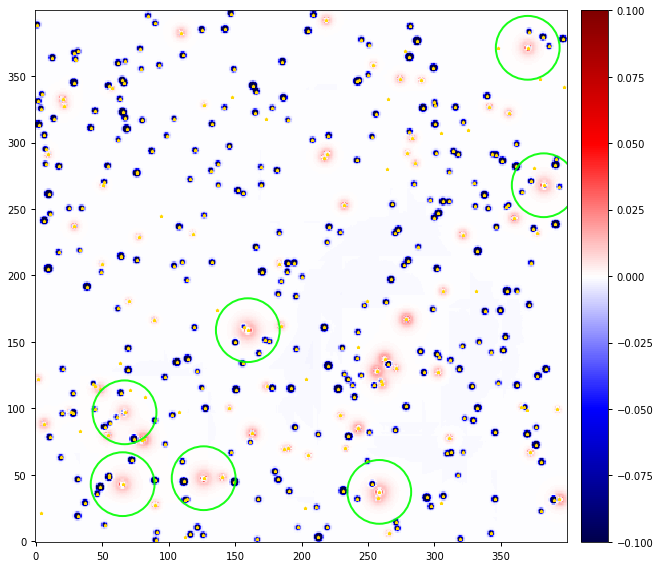

In [23]:
image_gs = make_truth_image(image_size, star_pos=star_pos, Flux=Flux,
                            noise=noise_image, parallel=parallel, method="Galsim")
plt.figure(figsize=(9,8))
im = plt.imshow((image_gs-image)/image, vmin=-0.1, vmax=0.1, origin="lower", cmap="seismic")
plt.scatter(star_pos[:,0], star_pos[:,1], marker="*", color="gold", s=8)
aper = CircularAperture(star_pos[verybright], r=24)
aper.plot(color='lime',lw=2,label="",alpha=0.9)
colorbar(im)
plt.tight_layout()
# plt.savefig("im_ratio.pdf")

Mask inner regions of stars in dual mode:  S/N < 2.5 or r < 24 pix 
Use sky strips crossing very bright stars


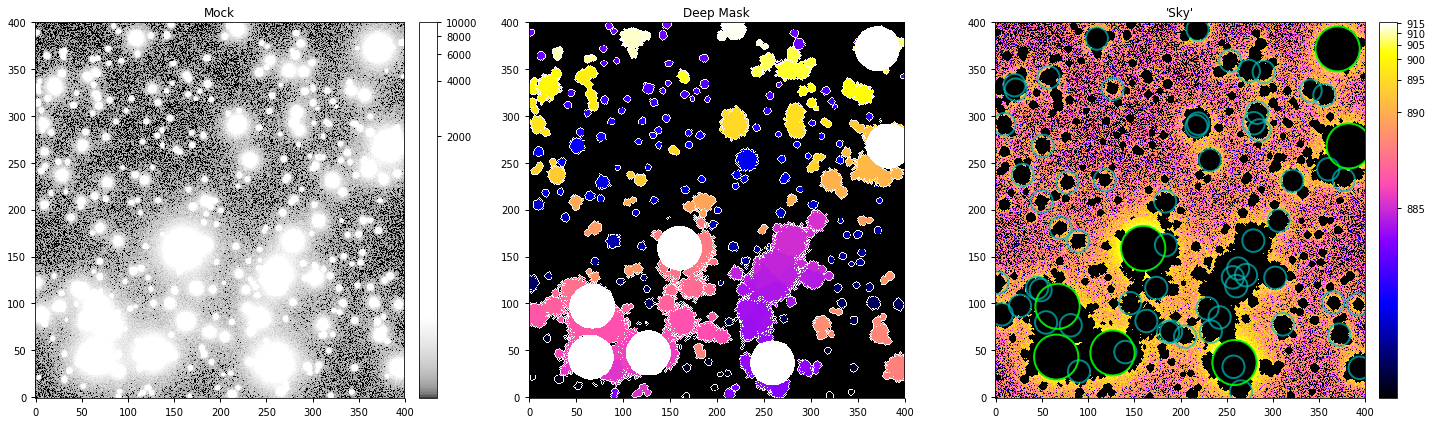

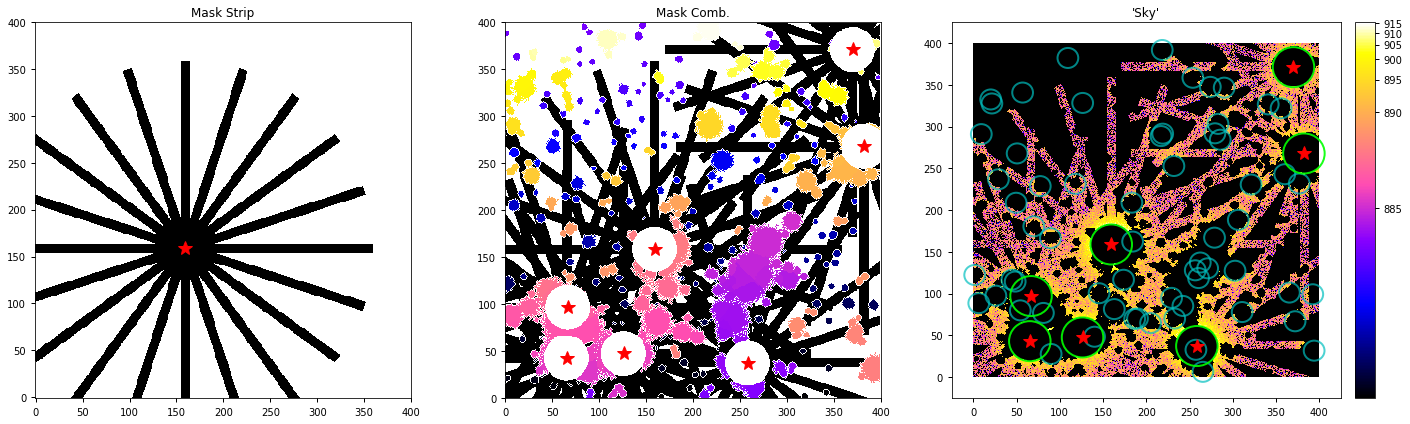

In [24]:
############################################
# Make Mask
############################################

# Make mask map for fitting
if mask_dual:
    print("Mask inner regions of stars in dual mode:  S/N < 2.5 or r < 24 pix ")
    mask_deep, seg_map, core_region = make_mask_map_dual(image, star_pos[verybright], 
                                                         r_in=24, nlevels=128, contrast=0.0001,
                                                         sn_thre=2.5, b_size=50, npix=4, n_dilation=1)
else:
    print("Mask inner regions of stars (threshold: S/N = 2.5)")
    mask_deep, seg_map = make_mask_map(image, sn_thre=2.5, b_size=25, npix=4, n_dilation=1)
    
if draw:
    fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(20,6))
    im1 = ax1.imshow(image, origin='lower', cmap='gray', norm=norm1, vmin=mu, vmax=1e4, aspect='auto')
    ax1.set_title("Mock")
    colorbar(im1)

    ax2.imshow(seg_map, origin="lower", cmap="gnuplot2")
    ax2.set_title("Deep Mask")

    image2 = image.copy()
    image2[mask_deep] = 0
    im3 = ax3.imshow(image2, cmap='gnuplot2', norm=norm2, vmin=mu, vmax=mu+10*sigma, origin='lower', aspect='auto') 
    ax3.set_title("'Sky'")
    colorbar(im3)

    aper = CircularAperture(star_pos[medbright], r=12)
    aper.plot(color='c',lw=2,label="",alpha=0.7, axes=ax3)
    aper = CircularAperture(star_pos[verybright], r=24)
    aper.plot(color='lime',lw=2,label="",alpha=0.9, axes=ax3)

    plt.tight_layout()


if mask_strip:
    print("Use sky strips crossing very bright stars")
    mask_strip_s = make_mask_strip(image_size, star_pos[verybright], Flux[verybright], 
                                   width=wid_strip, n_strip=n_strip, dist_strip=200)
    mask_strip_all = ~np.logical_or.reduce(mask_strip_s)
    seg_comb = seg_map.copy()
    seg_comb[mask_strip_all&(seg_map==0)] = seg_map.max()+1
    mask_comb = (seg_comb!=0)

    if draw:
        fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(20,6))
        ax1.imshow(mask_strip_s[-1], origin="lower", cmap="gray_r")
        ax1.plot(star_pos[Flux.argsort()][-1][0], star_pos[Flux.argsort()][-1][1], "r*",ms=15)
        ax1.set_title("Mask Strip")

        ax2.imshow(seg_comb, origin="lower", cmap="gnuplot2")
        ax2.plot(star_pos[verybright][:,0], star_pos[verybright][:,1], "r*",ms=15)
        ax2.set_xlim(0,image_size)
        ax2.set_ylim(0,image_size)
        ax2.set_title("Mask Comb.")

        image3 = image.copy()
        image3[mask_comb] = 0
        im3 = ax3.imshow(image3, cmap='gnuplot2', norm=norm1, aspect='auto', vmin=mu, vmax=mu+10*sigma, origin='lower') 
        ax3.plot(star_pos[verybright][:,0], star_pos[verybright][:,1], "r*",ms=15)
        ax3.set_xlim(-25,image_size+25)
        ax3.set_ylim(-25,image_size+25)
        ax3.set_title("'Sky'")
        colorbar(im3)
        
        aper = CircularAperture(star_pos[medbright], r=12)
        aper.plot(color='c',lw=2,label="",alpha=0.7, axes=ax3)
        aper = CircularAperture(star_pos[verybright], r=24)
        aper.plot(color='lime',lw=2,label="",alpha=0.9, axes=ax3)

        plt.tight_layout()



Total Time: 0.167s


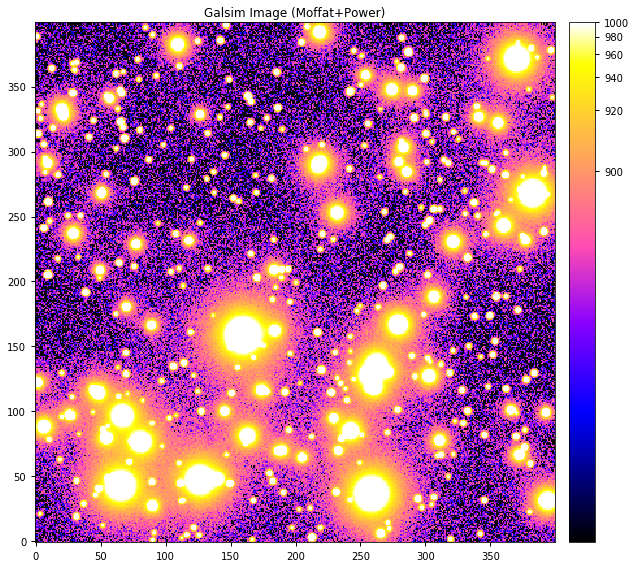

In [27]:
############################################
# Make Mock Image
############################################

def generate_image_galsim(n, mu, sigma, 
                          image_size=image_size,
                          min_psf_range=60, 
                          max_psf_range=720,
                          star_pos=star_pos,
                          Flux=Flux,
                          parallel=False,
                          interpolant='cubic'):
    
    psf_pow_b, psf_size = Generate_PSF_pow_Galsim(contrast=1e4, n=n, 
                                                psf_scale=pixel_scale, psf_range=None,  
                                                min_psf_range=min_psf_range//2, max_psf_range=max_psf_range//2,
                                                interpolant=interpolant) 
    psf_size = round_good_fft(psf_size)
    psf_star = psf_pow_b*frac + psf_mof*(1-frac)
    
    # Setup the canvas
    full_image = galsim.ImageF(image_size, image_size)
    
    # Draw medium bright stars with galsim in Fourier space
    if not parallel:
        # Draw in serial
        for k in range(num_medbright):
            draw_star(k, star_pos=star_pos[medbright], Flux=Flux[medbright],
                      psf_star=psf_star, psf_size=psf_size,
                      full_image=full_image)
    else:
        # Draw in parallel, automatically back to serial computing if too few jobs 
        p_get_stamp_bounds = partial(get_stamp_bounds,
                                     star_pos=star_pos[medbright],
                                     Flux=Flux[medbright]*frac,
                                     psf_star=psf_pow_b,
                                     psf_size=psf_size,
                                     full_image=full_image)
        
        results = parallel_compute(np.arange(num_medbright), p_get_stamp_bounds, 
                                   lengthy_computation=False, verbose=False)

        for (stamp, bounds) in results:
            full_image[bounds] += stamp[bounds]
           
    # Draw very bright star in real space / Fourier space       
#     if (n < 2.5) | (image_size<500):
#         draw_real = True
#     else: 
    draw_real = False
                   
    if draw_real:
        # Draw very bright star (if highter cost in FFT) in real space
        image_gs = full_image.array
        for (pos, flux) in zip(star_pos[verybright], Flux[verybright]):
            p2d_vb = trunc_power2d(xx, yy, n, cen=(pos[0],pos[1]),
                                   theta0=theta_t_pix, I_theta0=frac*flux * (n-2)/n /theta_t_pix**2/np.pi)
            image_gs += p2d_vb
    else:
        # Draw very bright star in Fourier space 
        psf_pow_vb , psf_size = Generate_PSF_pow_Galsim(contrast=1e5, n=n, 
                                                        psf_scale=pixel_scale, psf_range=None,  
                                                        min_psf_range=min_psf_range, max_psf_range=max_psf_range,
                                                        interpolant=interpolant)
        psf_size = round_good_fft(psf_size)
        psf_star = psf_pow_vb*frac + psf_mof*(1-frac)
        
        for k in range(num_verybright):
            draw_star(k, star_pos=star_pos[verybright], Flux=Flux[verybright],
                      psf_star=psf_star, psf_size=psf_size, full_image=full_image)
            
        image_gs = full_image.array
                   
    image = image_gs.copy() + image_gs0 + mu # add the faint star base and background

    return image

if draw:
    start = time.time()
    image_tri = generate_image_galsim(n=n, mu=mu, sigma=sigma, parallel=False, interpolant="cubic")
    end = time.time()
    print("\nTotal Time: %.3fs"%(end-start))

    plt.figure(figsize=(9,8))
    im = plt.imshow(image_tri, vmin=mu, vmax=1e3, norm=norm1, origin="lower", cmap="gnuplot2")
    plt.title("Galsim Image (Moffat+Power)")
    colorbar(im)
    plt.tight_layout()   

Fractional difference between truth image and generated synthetic image.

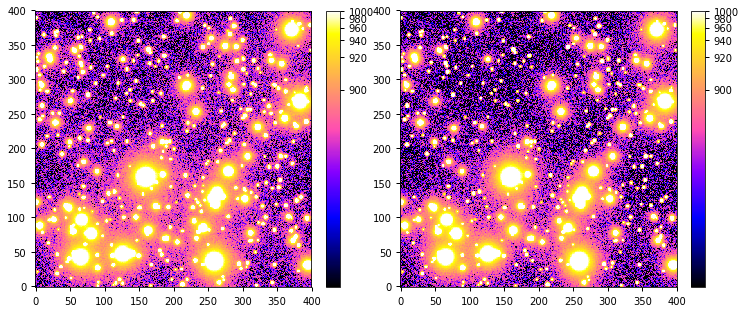

In [31]:
fig = plt.figure(figsize=(12,6))
ax=plt.subplot(121)
im = plt.imshow(image, vmin=mu, vmax=1e3, norm=norm1, origin="lower", cmap="gnuplot2")
colorbar(im)
ax=plt.subplot(122)
im = plt.imshow(image_tri+noise_image, vmin=mu, vmax=1e3, norm=norm1,origin="lower", cmap="gnuplot2")
colorbar(im)

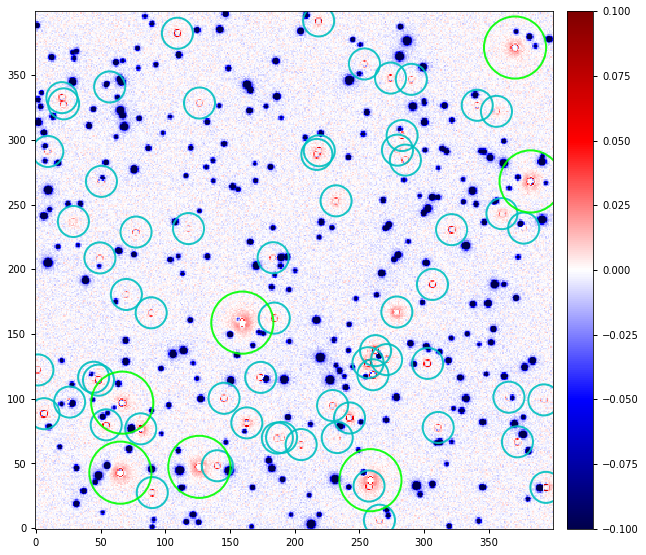

In [26]:
saturation=4.5e4
image_tri[image_tri>saturation] = saturation
    
plt.figure(figsize=(10,10))
ax=plt.subplot(111)
im = plt.imshow((image_tri-image)/image, vmin=-0.1, vmax=0.1, origin="lower", cmap="seismic")
colorbar(im)
aper = CircularAperture(star_pos[medbright], r=12)
aper.plot(color='c',lw=2,alpha=0.9,axes=ax)
aper = CircularAperture(star_pos[verybright], r=24)
aper.plot(color='lime',lw=2,alpha=0.9,axes=ax)

Truths:  [  2.8   884.      3.162]
Estimate of Background: (888.234, 4.072)


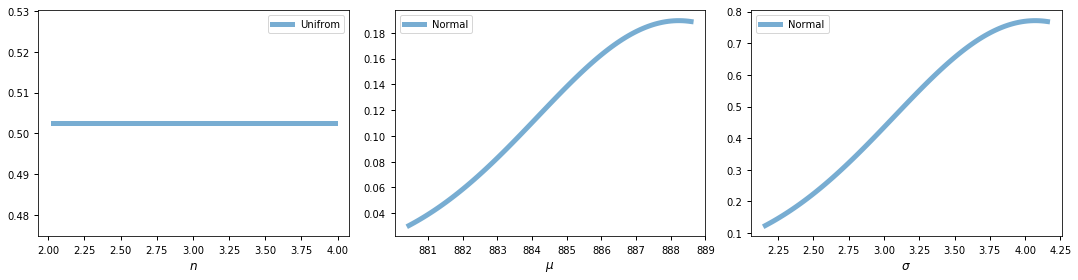

In [44]:
############################################
# Priors and Likelihood Models for Fitting
############################################

import dynesty
import time
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import multiprocess as mp

if mask_strip is True:
    mask_fit = mask_comb
else:
    mask_fit = mask_deep
    
labels = [r'$n$', r'$\mu$', r'$\sigma$']

truths = n, mu, sigma
print("Truths: ", np.around(truths, 3))

mu_patch, std_patch = np.median(image[~mask_fit]), mad_std(image[~mask_fit])
print("Estimate of Background: (%.3f, %.3f)"%(mu_patch, std_patch))

# Build Priors
Prior_n = stats.uniform(loc=2.01, scale=1.99)                         # n : 2-4
Prior_mu = stats.truncnorm(a=-2, b=0.1, loc=mu_patch, scale=std_patch)  # mu
Prior_sigma = stats.truncnorm(a=-2, b=0.1, loc=std_patch, scale=1)    # sigma 

Priors = [Prior_n, Prior_mu, Prior_sigma]
prior_tf = build_priors(Priors)

if draw:
    draw_prior(Priors, xlabels=labels, plabels=['Unifrom','Normal','Normal'])

X = np.array([xx,yy])
Y = image[~mask_fit].copy().ravel()

def loglike(v):
    n, mu, sigma = v
    
    image_tri = generate_image_galsim(n, mu, sigma, image_size=image_size)
    
    ypred = image_tri[~mask_fit].ravel()
    residsq = (ypred - Y)**2 / sigma**2
    loglike = -0.5 * np.sum(residsq + np.log(2 * np.pi * sigma**2))
    
    if not np.isfinite(loglike):
        loglike = -1e100
        
    return loglike

def Run_Nested_Fitting(loglike=loglike, 
                       prior_transform=prior_tf, ndim=3, 
                       nlive_init=200, nlive_batch=100, maxbatch=3,
                       print_progress=True):
        
    with mp.Pool(processes=n_cpu-1) as pool:
        print("Opening pool: # of CPU used: %d"%(n_cpu))
        pool.size = n_cpu

        dlogz = 1e-3 * (nlive_init - 1) + 0.01

        pdsampler = dynesty.DynamicNestedSampler(loglike, prior_transform, ndim,
                                                  pool=pool, use_pool={'update_bound': False})
        pdsampler.run_nested(nlive_init=nlive_init, 
                             nlive_batch=nlive_batch, 
                             maxbatch=maxbatch,
                             print_progress=print_progress, 
                             dlogz_init=dlogz, 
                             wt_kwargs={'pfrac': 0.8})
    return pdsampler

(New) 3-parameter fitting (ignoring inner part in modeling)

Opening pool: # of CPU used: 3


iter: 2236 | batch: 2 | bound: 44 | nc: 2 | ncall: 9959 | eff(%): 22.452 | loglstar: -156642.713 < -156640.007 < -156641.081 | logz: -156657.006 +/-  0.559 | stop:  5.118                            


Finish Fitting! Total time elapsed: 1.47e+03s


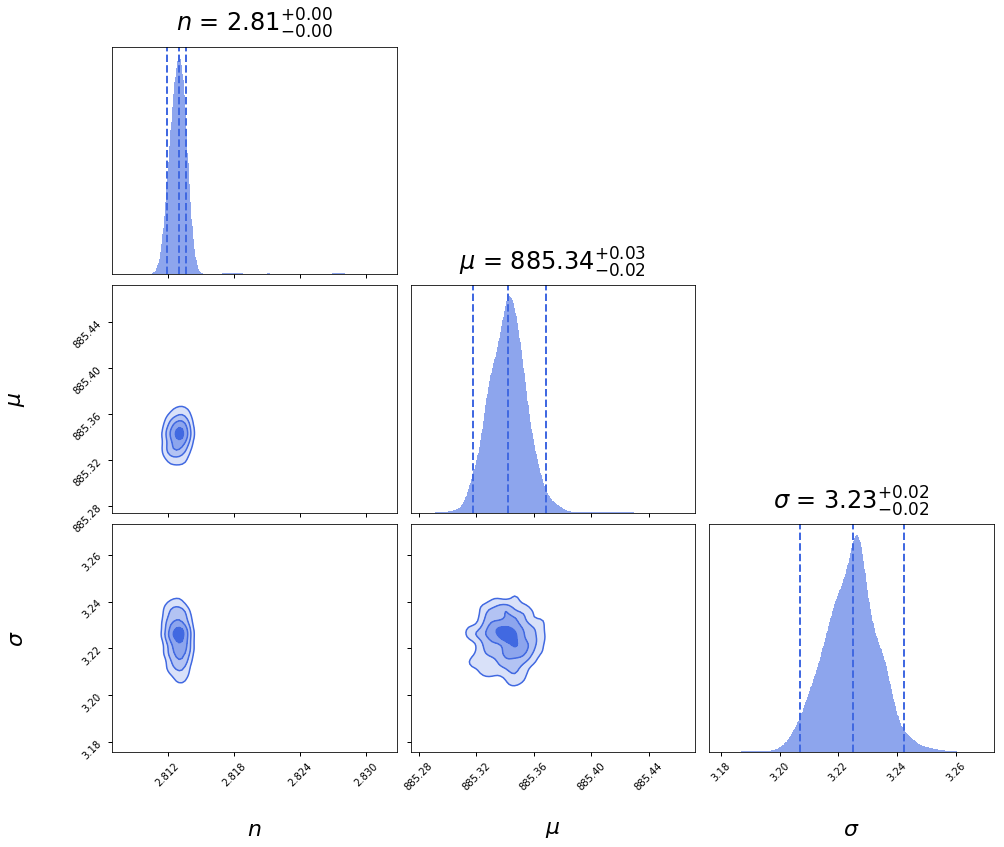

In [45]:
############################################
# Fitting
############################################

if RUN_FITTING:
    start = time.time()
    pdsampler = Run_Nested_Fitting(loglike, prior_tf, ndim=3,
                                   nlive_init=100, nlive_batch=50, maxbatch=2)
    end = time.time()
    print("Finish Fitting! Total time elapsed: %.3gs"%(end-start))
    
    pdres = pdsampler.results

    # Plot Result
    fig, axes = dyplot.cornerplot(pdres, truths=truths, show_titles=True, 
                                  color="royalblue", truth_color="indianred",
                                  title_kwargs={'fontsize':24, 'y': 1.04}, labels=labels,
                                  label_kwargs={'fontsize':22},
                                  fig=plt.subplots(3, 3, figsize=(15, 12)))

(Old) 4-parameter fitting (inc. a dummy parameter fraction of power law)

Opening pool: # of CPU used: 3


iter: 5735 | batch: 3 | bound: 55 | nc: 2 | ncall: 20107 | eff(%): 28.522 | loglstar: -341952.673 < -341948.782 < -341948.808 | logz: -341967.236 +/-  0.409 | stop:  2.957                           


Finish Fitting! Total time elapsed: 3.81e+03s


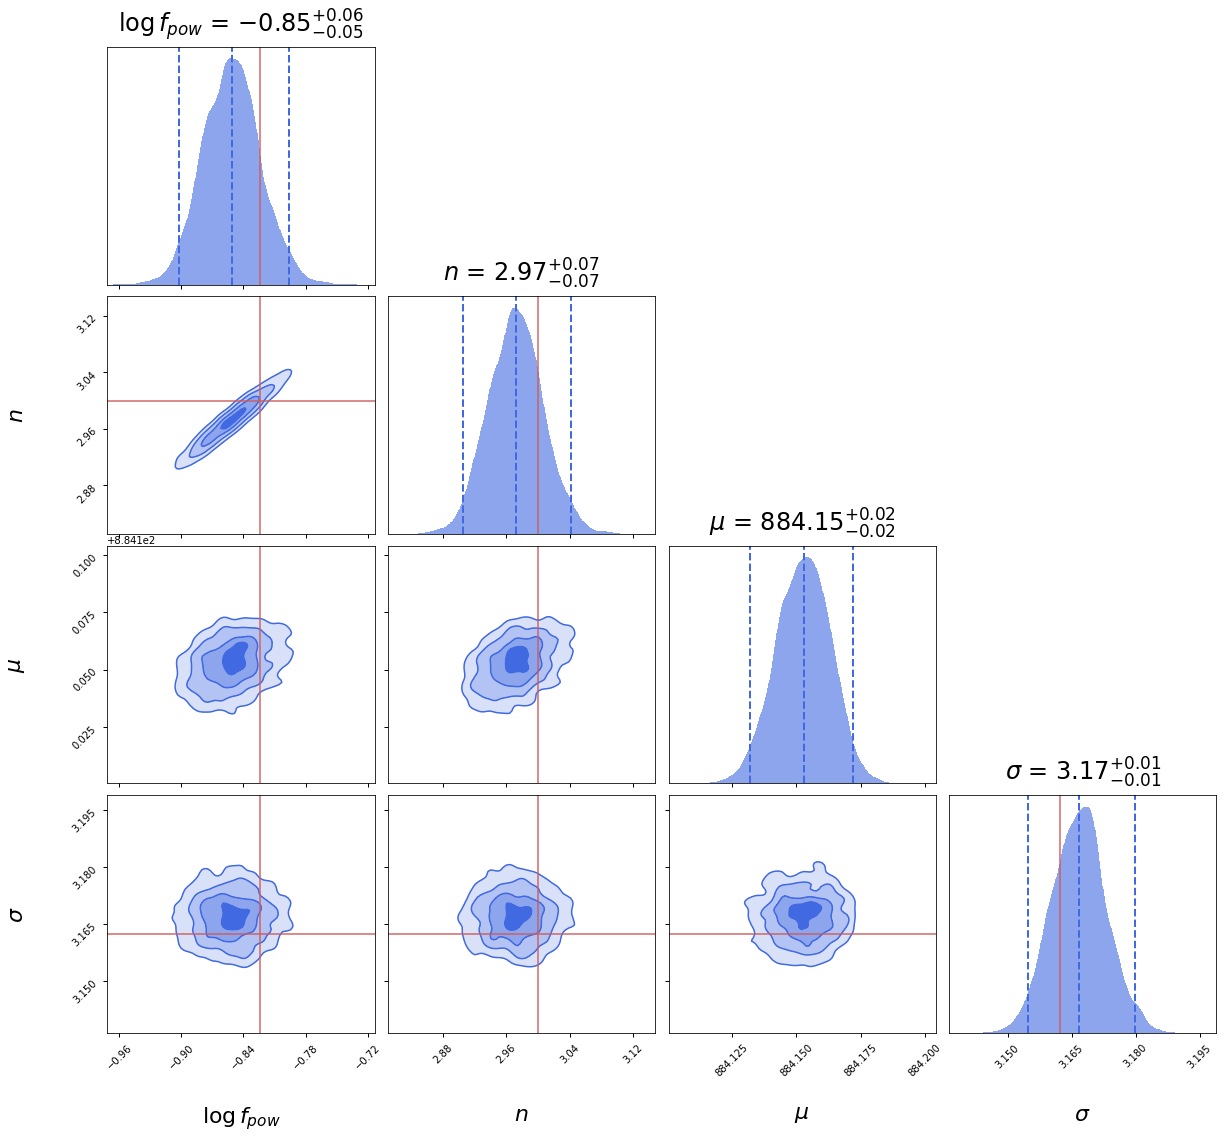

In [11]:
############################################
# Fitting
############################################

if RUN_FITTING:
    start = time.time()
    pdsampler = Run_Nested_Fitting(loglike, prior_transform, truths=truths)
    end = time.time()
    print("Finish Fitting! Total time elapsed: %.3gs"%(end-start))
    
    pdres = pdsampler.results
    save_nested_fitting_result(pdres, filename='%s/fit.res'%dir_name)
    pdres = pdsampler.results

    # Plot Result
    fig, axes = dyplot.cornerplot(pdres, truths=truths, show_titles=True, 
                                  color="royalblue", truth_color="indianred",
                                  title_kwargs={'fontsize':24, 'y': 1.04}, labels=labels,
                                  label_kwargs={'fontsize':22},
                                  fig=plt.subplots(4, 4, figsize=(18, 16)))

In [242]:
def plot_fitting_vs_truth_PSF(res, true_pars, image_size=image_size, 
                              n_bootstrap=200, save=True, dir_name="."):
    
    samples = res.samples                                 # samples
    weights = np.exp(res.logwt - res.logz[-1])            # normalized weights 
    pmean, pcov = dyfunc.mean_and_cov(samples, weights)     # weighted mean and covariance
    samples_eq = dyfunc.resample_equal(samples, weights)  # resample weighted samples
    pmed = np.median(samples_eq,axis=0)                    # median sample
    print("Fitting (mean): ", pmean)
    print("Fitting (median): ", pmed)
    
    from astropy.stats import bootstrap
    samples_eq_bs = bootstrap(samples_eq, bootnum=1, samples=n_bootstrap)[0]
    
    gamma, alpha, frac, n = true_pars.values()
    
    C_mof2Dto1D =  1./(beta_psf-1) * 2*math.sqrt(np.pi) * gamma_pix * Gamma(beta_psf) / Gamma(beta_psf-1./2) 
    C_pow2Dto1D = np.pi * theta_t_pix * (n-1) / (n-2)
    
    r = np.logspace(0., np.log10(image_size//2), 100)
    comp1 = moffat1d_normed(r, gamma=gamma, alpha=alpha) / C_mof2Dto1D
    comp2 = trunc_power1d_normed(r, n, theta_t_pix) / C_pow2Dto1D
    
    plt.figure(figsize=(7,6))
    
    plt.plot(r, np.log10((1-frac) * comp1 + frac * comp2),
                 label="Truth", color="steelblue", lw=4, zorder=2)
    for (n_k, _, _) in samples_eq_bs:
        frac_k = 0.3 #10**logfrac_k
        comp2_k = trunc_power1d_normed(r, n_k, theta_t_pix) / C_pow2Dto1D

        plt.plot(r, np.log10((1-frac_k) * comp1 + frac_k * comp2_k),
                     color="lightblue", lw=1.5,alpha=0.1,zorder=1)
    else:
        for fits, c, ls, l in zip([pmed, pmean], ["royalblue", "b"],
                                  ["-.","--"], ["mean", "med"]):
            f_fit = 0.3 #10**fits[0]
            comp2 = trunc_power1d_normed(r, fits[0], theta_t_pix) / C_pow2Dto1D
            y_fit = (1-f_fit) * comp1 + f_fit * comp2
            
            plt.plot(r, np.log10(y_fit), color=c, lw=2.5, ls=ls, alpha=0.8, label=l, zorder=4)
            if l=="med":
                plt.plot(r, np.log10((1-f_fit) * comp1),
                             color="orange", lw=2, ls="--", alpha=0.7, label="med mof",zorder=4)
                plt.plot(r, np.log10(f_fit * comp2),
                             color="seagreen", lw=2, ls="--", alpha=0.7, label="med pow",zorder=4)
    
    plt.legend(fontsize=12)    
    plt.xlabel(r"$\rm r\,[pix]$",fontsize=18)
    plt.ylabel(r"$\rm \log\,Intensity$",fontsize=18)
    plt.title("Recovered PSF from Fitting",fontsize=18)
    plt.xscale("log")
    plt.ylim(-7, -0.5)
    plt.tight_layout()
    if save:
        plt.savefig("%s/Fit_PSF.png"%dir_name,dpi=150)
        plt.close()

Fitting (mean):  [  3.10294695 884.69743191   3.21570259]
Fitting (median):  [  3.10477135 884.69805462   3.21601438]


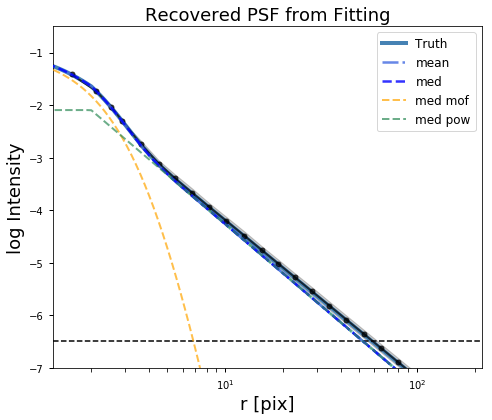

In [244]:
plot_fitting_vs_truth_PSF(pdres, n_bootstrap=300, image_size=image_size, save=False, dir_name=dir_name,
                          true_pars = {"gamma":gamma_pix, "alpha":beta_psf, "frac":frac, "n":n})
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(img_gs_2, pix_scale=pixel_scale, seeing=2.5, color="k",   
                                             core_undersample=True,xunit="pix", yunit="intensity", label="Galsim PSF")
plt.axhline(np.log10(img_gs_2.max()/(Amps_mof.max()/sigma*3)),color="k",ls="--")